In [1]:
import sys
sys.path.append('../../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
from tqdm import tqdm
from typing import Tuple, List
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob 
from dateutil import parser
import dateutil
import transformers
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
import warnings
warnings.filterwarnings("ignore")
from scripts.get_train_test import normalize_target
from scripts.metrics import get_metrics, plot_two_distributions

In [4]:
from glob import glob 
files = glob("../../scripts/asses/*")
files[:5]    

['../../scripts/asses/836701331.json',
 '../../scripts/asses/124904307.json',
 '../../scripts/asses/551837411.json',
 '../../scripts/asses/159036219.json',
 '../../scripts/asses/543766883.json']

In [5]:
import json
from collections import Counter
from tqdm import tqdm 

result = {"vk_id": [0] * len(files), 
          "negative":[0] * len(files), 
          "neutral":[0] * len(files), 
          "positive":[0] * len(files), 
          "skip":[0] * len(files),
         "speech": [0] * len(files),
          "n_messages": [0] * len(files)
         }
i = 0
for file in tqdm(files):
    sentiments = json.load(open(file))
    sents = list(sentiments.values())[0][-1]
    result["vk_id"][i] = int(list(sentiments.keys())[0])
    result["n_messages"][i] = len(sents)
    c = Counter(sents)
    for k, v in c.items():
        c[k] = v / len(sents)
        result[k][i] = float(c[k])
    i+=1
        


100%|██████████| 391/391 [00:04<00:00, 94.38it/s] 


In [6]:
# collect all sentiments and get normalized scores 

In [7]:
data_sentiment = pd.DataFrame(result)
data_sentiment

,vk_id,negative,neutral,positive,skip,speech,n_messages
0,836701331,0.000000,0.500000,0.000000,0.000000,0.500000,2
1,124904307,0.109005,0.710900,0.056872,0.123223,0.000000,211
2,551837411,0.041667,0.833333,0.083333,0.041667,0.000000,24
3,159036219,0.079562,0.796596,0.061948,0.050187,0.011707,18451
4,543766883,0.063830,0.670213,0.175532,0.069149,0.021277,188
...,...,...,...,...,...,...,...
386,999546489,0.111367,0.661935,0.082681,0.138976,0.005042,20428
387,505150943,0.054348,0.760870,0.141304,0.021739,0.021739,92
388,866133908,0.016393,0.868852,0.060109,0.038251,0.016393,183
389,670060741,0.198520,0.620760,0.069518,0.095673,0.015529,22023


<AxesSubplot:ylabel='Frequency'>

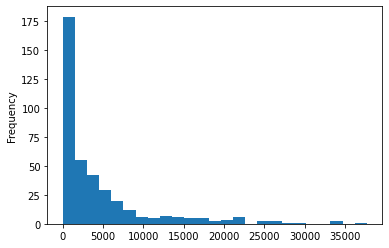

In [8]:
data_sentiment.n_messages.plot.hist(bins=25)

<AxesSubplot:>

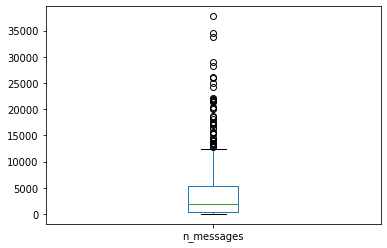

In [9]:
data_sentiment.n_messages.plot.box()

In [10]:
data_sentiment.describe()

,vk_id,negative,neutral,positive,skip,speech,n_messages
count,3.910000e+02,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000
mean,4.916031e+08,0.090163,0.697606,0.100820,0.077006,0.034405,4311.741688
std,2.837385e+08,0.048793,0.101928,0.050722,0.055172,0.066735,6249.232982
min,5.493755e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.380157e+08,0.061775,0.647724,0.073712,0.049410,0.011332,291.500000
50%,5.051509e+08,0.087458,0.696636,0.096823,0.068424,0.018981,1827.000000
75%,7.363921e+08,0.117676,0.746498,0.123193,0.093572,0.036961,5290.000000
max,9.995465e+08,0.304211,1.000000,0.344000,0.652174,1.000000,37722.000000


In [11]:
data_sentiment.n_messages.quantile(0.10)

39.0

In [12]:
def get_base_data():
    base_path = "../../data/Data DigitalFreud/final_data/"
    base_info_path = '1/item1.csv'

    base_info_file = os.path.join(base_path, base_info_path)
    base_info = pd.read_csv(base_info_file)
    base_info = base_info[(base_info.who_score.notna()) & (base_info.diener_score.notna())]
    return base_info
base_info = get_base_data()
norm_data = normalize_target(base_info, "who_score", "diener_score")

In [13]:
collect = {"who_score":[], "diener_score":[]}
for vk_id in result["vk_id"]:
    who, diener = norm_data[norm_data["vk_id_encrypted"] == int(vk_id)].who_score.values, \
        norm_data[norm_data["vk_id_encrypted"] == int(vk_id)].diener_score.values
    collect["who_score"].append(who[0] if who[0] else np.nan)
    collect["diener_score"].append(diener[0] if diener[0] else np.nan)
collect

{'who_score': [0.6,
  0.56,
  0.48,
  0.4,
  0.32,
  0.44,
  0.6,
  0.48,
  0.52,
  0.84,
  0.56,
  0.44,
  0.6,
  0.4,
  0.32,
  0.4,
  0.2,
  0.2,
  0.8,
  0.44,
  0.68,
  0.16,
  0.36,
  0.08,
  0.36,
  0.44,
  0.52,
  0.4,
  0.24,
  0.84,
  0.6,
  0.76,
  0.48,
  0.32,
  0.28,
  0.24,
  0.92,
  0.44,
  0.56,
  0.36,
  0.16,
  0.68,
  0.44,
  0.6,
  0.28,
  0.4,
  0.4,
  0.56,
  0.6,
  0.28,
  0.76,
  0.92,
  0.56,
  0.24,
  0.44,
  0.36,
  0.56,
  0.24,
  0.72,
  0.52,
  0.6,
  0.36,
  0.28,
  0.4,
  0.4,
  0.48,
  0.28,
  0.44,
  0.36,
  0.88,
  0.44,
  0.28,
  0.48,
  0.68,
  0.52,
  0.8,
  0.76,
  0.24,
  0.48,
  0.2,
  0.6,
  0.08,
  0.68,
  0.56,
  0.24,
  0.64,
  0.2,
  0.08,
  0.52,
  0.72,
  0.36,
  0.24,
  0.24,
  0.32,
  0.2,
  0.4,
  0.16,
  0.24,
  0.32,
  0.64,
  0.48,
  0.68,
  0.28,
  0.24,
  0.32,
  0.76,
  0.8,
  0.44,
  0.36,
  0.44,
  0.6,
  0.24,
  0.48,
  0.52,
  0.52,
  0.6,
  0.44,
  0.4,
  0.8,
  0.24,
  0.8,
  0.56,
  0.2,
  0.44,
  0.4,
  0.64,
  0.72,
  0

In [14]:
result.update(collect)

In [15]:
relative_features = pd.DataFrame(result)
relative_features = relative_features.dropna()

In [16]:
relative_features

,vk_id,negative,neutral,positive,skip,speech,n_messages,who_score,diener_score
0,836701331,0.000000,0.500000,0.000000,0.000000,0.500000,2,0.60,0.566667
1,124904307,0.109005,0.710900,0.056872,0.123223,0.000000,211,0.56,0.300000
2,551837411,0.041667,0.833333,0.083333,0.041667,0.000000,24,0.48,0.300000
3,159036219,0.079562,0.796596,0.061948,0.050187,0.011707,18451,0.40,0.500000
4,543766883,0.063830,0.670213,0.175532,0.069149,0.021277,188,0.32,0.333333
...,...,...,...,...,...,...,...,...,...
386,999546489,0.111367,0.661935,0.082681,0.138976,0.005042,20428,0.32,0.200000
387,505150943,0.054348,0.760870,0.141304,0.021739,0.021739,92,0.36,0.366667
388,866133908,0.016393,0.868852,0.060109,0.038251,0.016393,183,0.48,0.600000
389,670060741,0.198520,0.620760,0.069518,0.095673,0.015529,22023,0.56,0.066667


In [17]:
# import pandas as pd

# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)

# relative_features = clean_dataset(relative_features)

In [18]:
relative_sentiment_features = relative_features[relative_features.n_messages > 30]

In [19]:
relative_sentiment_features

,vk_id,negative,neutral,positive,skip,speech,n_messages,who_score,diener_score
1,124904307,0.109005,0.710900,0.056872,0.123223,0.000000,211,0.56,0.300000
3,159036219,0.079562,0.796596,0.061948,0.050187,0.011707,18451,0.40,0.500000
4,543766883,0.063830,0.670213,0.175532,0.069149,0.021277,188,0.32,0.333333
5,454945955,0.074127,0.578625,0.216985,0.094998,0.035264,2779,0.44,0.166667
6,992109610,0.100917,0.651376,0.128440,0.018349,0.100917,109,0.60,0.566667
...,...,...,...,...,...,...,...,...,...
386,999546489,0.111367,0.661935,0.082681,0.138976,0.005042,20428,0.32,0.200000
387,505150943,0.054348,0.760870,0.141304,0.021739,0.021739,92,0.36,0.366667
388,866133908,0.016393,0.868852,0.060109,0.038251,0.016393,183,0.48,0.600000
389,670060741,0.198520,0.620760,0.069518,0.095673,0.015529,22023,0.56,0.066667


In [20]:
relative_sentiment_features.describe()

,vk_id,negative,neutral,positive,skip,speech,n_messages,who_score,diener_score
count,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,4.932065e+08,0.096025,0.690894,0.103445,0.079915,0.029721,4719.502874,0.453563,0.435153
std,2.814449e+08,0.044059,0.073549,0.043010,0.051929,0.029742,6371.659560,0.191099,0.218192
min,5.493755e+06,0.000000,0.347826,0.000000,0.000000,0.000000,31.000000,0.040000,0.033333
25%,2.447757e+08,0.068786,0.647172,0.076863,0.052632,0.012669,660.750000,0.320000,0.266667
50%,5.065463e+08,0.091152,0.695449,0.098074,0.069971,0.019621,2415.500000,0.440000,0.433333
75%,7.352106e+08,0.118324,0.741313,0.123145,0.093727,0.037113,5688.000000,0.560000,0.600000
max,9.995465e+08,0.304211,0.891105,0.344000,0.652174,0.230769,37722.000000,0.960000,0.966667


In [21]:
relative_sentiment_features.n_messages.median()

2415.5

In [22]:
relative_sentiment_features.corr()

,vk_id,negative,neutral,positive,skip,speech,n_messages,who_score,diener_score
vk_id,1.000000,0.004982,0.075682,0.006971,-0.098851,-0.032023,0.004719,0.077584,0.022131
negative,0.004982,1.000000,-0.523798,-0.107024,0.198462,-0.377819,0.272377,-0.149210,-0.223397
neutral,0.075682,-0.523798,1.000000,-0.456751,-0.596635,0.005259,-0.182286,0.093990,0.071447
positive,0.006971,-0.107024,-0.456751,1.000000,-0.150687,0.105039,-0.001320,0.024321,0.030248
skip,-0.098851,0.198462,-0.596635,-0.150687,1.000000,-0.346638,0.193236,-0.114221,-0.056191
speech,-0.032023,-0.377819,0.005259,0.105039,-0.346638,1.000000,-0.288192,0.152864,0.208617
n_messages,0.004719,0.272377,-0.182286,-0.001320,0.193236,-0.288192,1.000000,-0.158196,-0.121992
who_score,0.077584,-0.149210,0.093990,0.024321,-0.114221,0.152864,-0.158196,1.000000,0.513807
diener_score,0.022131,-0.223397,0.071447,0.030248,-0.056191,0.208617,-0.121992,0.513807,1.000000


In [50]:
data_sentiment.n_messages.median()

2415.5

In [23]:
relative_sentiment_features.corr()["who_score"]

vk_id           0.077584
negative       -0.149210
neutral         0.093990
positive        0.024321
skip           -0.114221
speech          0.152864
n_messages     -0.158196
who_score       1.000000
diener_score    0.513807
Name: who_score, dtype: float64

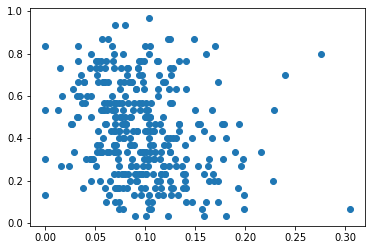

In [35]:
plt.scatter(relative_sentiment_features.negative, relative_sentiment_features.diener_score)

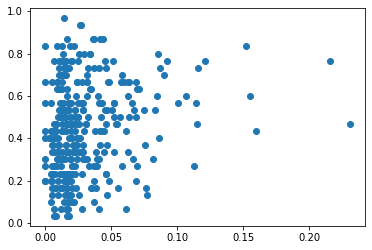

In [36]:
plt.scatter(relative_sentiment_features.speech, relative_sentiment_features.diener_score)

In [37]:
# all features

Report:
mean_squared_error: 0.0334
mean_absolute_error: 0.1447
r2_score 0.0134
pearsonr_corr: 0.1243, pearsonr_p: 0.2515
spearman_corr: 0.092, spearman_p: 0.3965



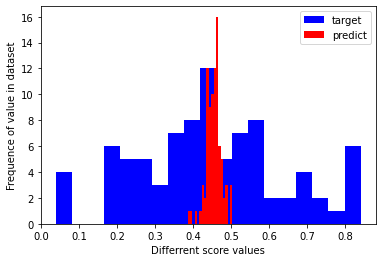

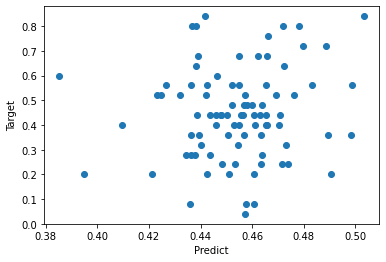

In [25]:
def eval_features(columns, target):
    X_train, X_test, y_train, y_test = train_test_split(
        relative_sentiment_features[columns], 
        relative_sentiment_features[target].values, random_state=0
    )
    pipe = Ridge()
    pipe.fit(X_train, y_train)
    predicted_y = pipe.predict(X_test)
    get_metrics(y_test, predicted_y)
    plot_two_distributions(y_test, predicted_y)
    
eval_features(['negative', 'neutral', 'positive', 'skip', 'speech'], "who_score")

Report:
mean_squared_error: 0.0335
mean_absolute_error: 0.1445
r2_score 0.0121
pearsonr_corr: 0.1265, pearsonr_p: 0.243
spearman_corr: 0.1095, spearman_p: 0.3125



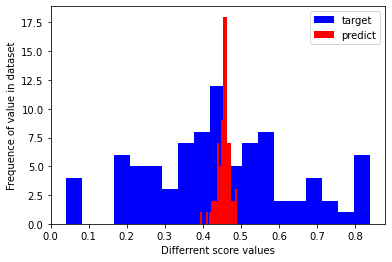

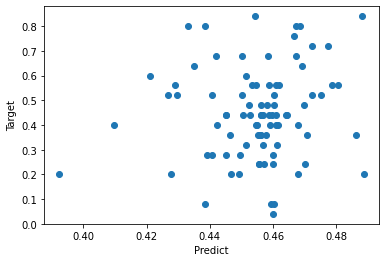

In [26]:
eval_features(['negative', 'neutral', 'positive'], "who_score")

Report:
mean_squared_error: 0.0334
mean_absolute_error: 0.1447
r2_score 0.0148
pearsonr_corr: 0.136, pearsonr_p: 0.2093
spearman_corr: 0.087, spearman_p: 0.423



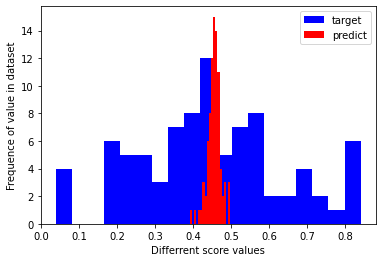

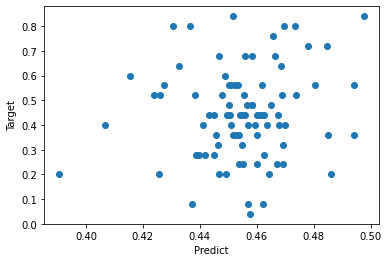

In [27]:
eval_features(['negative', 'neutral', 'positive', 'speech'], "who_score")

Report:
mean_squared_error: 0.0543
mean_absolute_error: 0.1988
r2_score -0.0123
pearsonr_corr: 0.0372, pearsonr_p: 0.7323
spearman_corr: 0.1524, spearman_p: 0.1589



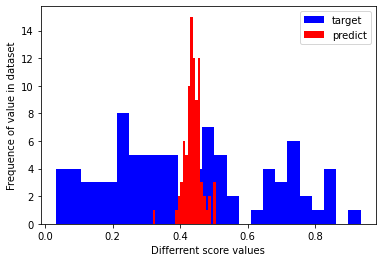

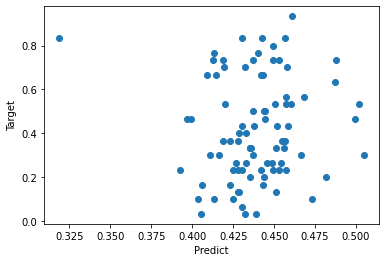

In [39]:
eval_features(['negative', 'neutral', 'positive', 'skip', 'speech'], "diener_score")

In [40]:
# only most correlated

Report:
mean_squared_error: 0.0536
mean_absolute_error: 0.1975
r2_score 0.0002
pearsonr_corr: 0.0929, pearsonr_p: 0.3919
spearman_corr: 0.1645, spearman_p: 0.1279



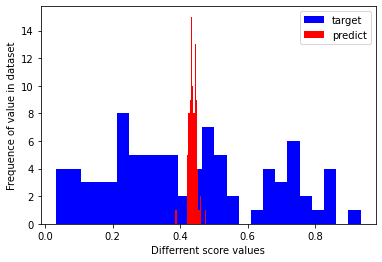

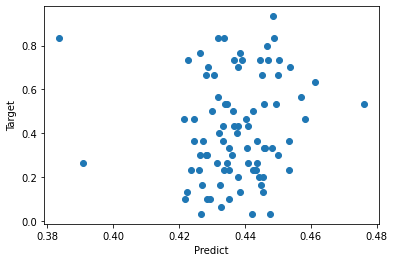

In [41]:
eval_features([ 'neutral', 'speech'], "diener_score")

Report:
mean_squared_error: 0.0335
mean_absolute_error: 0.1447
r2_score 0.0124
pearsonr_corr: 0.1369, pearsonr_p: 0.206
spearman_corr: 0.125, spearman_p: 0.2485



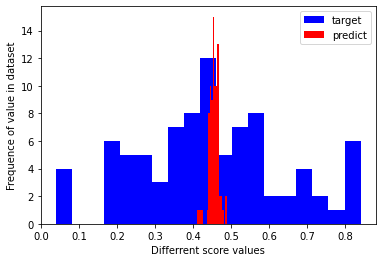

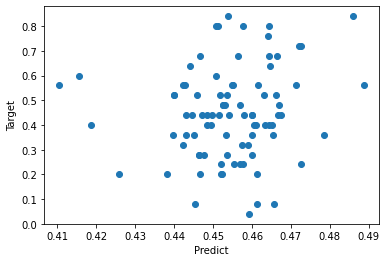

In [27]:
eval_features([ 'neutral', 'speech'], "who_score")

In [28]:
# only sentiment features

Report:
mean_squared_error: 0.0459
mean_absolute_error: 0.181
r2_score -0.0825
pearsonr_corr: 0.0932, pearsonr_p: 0.3906
spearman_corr: 0.0889, spearman_p: 0.4131



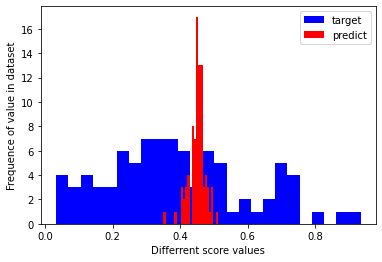

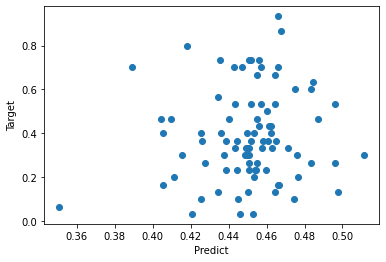

In [29]:
eval_features(['negative', 'neutral', 'positive'], "diener_score")

Report:
mean_squared_error: 0.0335
mean_absolute_error: 0.1445
r2_score 0.0121
pearsonr_corr: 0.1265, pearsonr_p: 0.243
spearman_corr: 0.1095, spearman_p: 0.3125



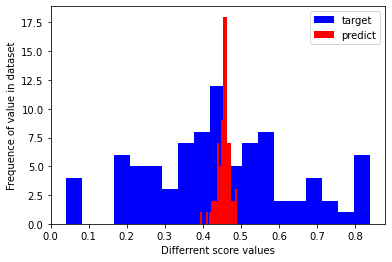

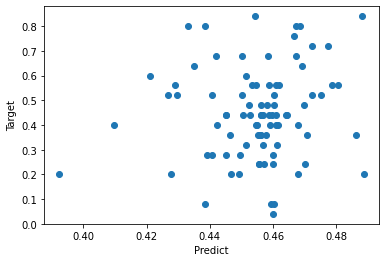

In [30]:
eval_features(['negative', 'neutral', 'positive'], "who_score")